**Due date is Wednesday, February 17, 2021, 23:59 PST**

**ONLY write into the existing cells, and do NOT add any cells.**

# ELEC 400M / EECE 571M Assignment 1: Linear models for classification
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will be using linear models discussed in the lectures to perform a binary classification task. You will compare the performances of linear classification and logistic regression using suitable training algorithms. The implementation will be done in python using functions from the **NumPy** library. Please use **NumPy arrays** as data structures.

## Data Set
We consider the dataset of images of letters contained in file notMNIST.npz. In particular, you will use a smaller dataset that only contains the images from two letter classes: “C” (the positive class) and “J” (the negative class). The images are of size 28 × 28 pixels. The figure below shows 20 randomly selected image samples for the letters “C” and “J”.

<img src="sample_images.png" width="400">

You will apply the function `loadData` to generate the subset of images containing only letters “C” and “J”. This script organizes the total set of 3,745 images into smaller subsets containing 3,500 training images, 100 validation images and 145 test images. Their use will be further specified in the problem descriptions below.

Execute the two helper scripts provided below.

In [3]:
%reset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.0
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(1)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
           
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Linear Classification

The first classifier is the linear classifier 
$$\hat{y}=\mathrm{sign}\left(\sum_{i=0}^dw_ix_i\right)\,$$
where $x_0=1$ so that $b=w_0x_0$ is the bias term and $x_1,\ldots, x_d$ are the input features.
The loss function for an input-output pair $(\underline{x}_n,y_n)$ and given model parameters $\underline{w}$ is 
$$L_n(\underline{w})= \mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$
The total loss for $N$ samples is 
$$L(\underline{w})= \frac{1}{N}\sum\limits_{n=1}^N\mathbf{1}\{\hat{y}_n\neq y_n\}\;.$$



### Notes on classification
* The classification should be based on the $d=28\times 28=784$ intensity values in an image. This means that you need to flatten the 2D images to 1D input vectors $\underline{x}$ of length 784.
* The outputs $\hat{y}$ of the perceptron model are from $\{-1,+1\}$, while the target variable from the data set is from $\{0,1\}$. You need to make adjustements to account for this difference, which can include adjusting the data type.

### Loss Function [2 points]

Implement a function to compute the classification loss as defined above. The function has three input arguments: the weight vector, the feature vectors, and the labels. The binary labels are assumed to be from $\{-1,+1\}$. It returns the total loss (normalized with $N$, as above) associated with the input.

In [5]:
def ErrorRate (w, x, y):
    """Compute error rate for binary linear classifier"""
    # YOUR CODE HERE
    N = len(y)
    y_hat = np.sign(np.dot(x,w))
    y_hat[y_hat<1]=-1
    Ln_w = [int(i) for i in y != y_hat]
    Ln_w = np.array(Ln_w)
    return (float)(Ln_w.reshape(len(y),1).sum())/N 

In [6]:
"""Check that ErrorRate returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.) )"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[-1],[1],[-1]])
assert np.abs(ErrorRate(wtest1,xtest1,ytest1)-0.25)<0.01 
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[-1],[-1],[1],[1]])
assert np.abs(ErrorRate(wtest2,xtest2,ytest2)-0.0)<0.01 
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[-1],[1],[1],[1]])
assert np.abs(ErrorRate(wtest3,xtest3,ytest3)-0.6)<0.01 

### Perceptron Learning Algorithm [10 points]

Implement a function for the perceptron learning algorithm (PLA) which accepts four arguments: an inital weight vector, the data, the labels (binary $\{-1,+1\}$), and the maximal number of iterations it executes. It is thus a version of the PLA that is assured to terminate. The function returns the updated weight vector. 

**Note:** To pass the test cases, your PLA needs to select the misclassified sample to perform a model update in a deterministic manner as follows: from the training data $\{(x_1,y_1,), (x_2,y_2), \ldots,(x_N,y_N)\}$ select the misclassified sample $(x_i,y_i)$ with the smallest index $i$ for the PLA update.

In [7]:
def PLA(w, x, y, maxIter):

    # YOUR CODE HERE
    #Initialize
    N = len(x) #Height of the matrix
    y_hat = np.zeros( shape = (N,1))#Create an N size matrix
    t = 0
    i = 0
    x_flat = x.flatten()
    dot_product = int(0)
    #w = np.array([[0],[0],[0]])
    # print(ErrorRate(w_upd[t].reshape(N_w,1),x,y))
    if(x.ndim == 2):
        while ( (ErrorRate(w,x,y) > 0) & (t < maxIter ) ):
            i = 0
            j = 0
            while( i < N):
                dot_product = 0
                if(j <= len(x)):  # 0:2 3:5 6:8 9: 11
                    dot_product = dot_product + np.dot(x[j],w)
                    j = j + 1
                if(dot_product > [0]):
                    y_hat[i] = 1
                else:
                    y_hat[i] = -1

                if ((y_hat[i] != y[i])): #misclassified sample
                    if(y_hat[i] == [1]):
                        w = w.T
                        w = w - x[i]
                        w = w.T
                        i = N
                    else:
                        w = w.T
                        w = w + x[i]
                        w = w.T
                        i = N
                else:
                    w = w
                i = i + 1
                
            #print(t)
            t = t + 1
            #print (t) for testing
        return w

    elif(x.ndim == 3):
        while ( (ErrorRate(w,x,y) > 0) & (t < maxIter ) ):
            i = 0
            while(i < N):
                x_2d = x[i].flatten()  # x is now (1 x 784) and our w is 784 x 1
                dot_product = np.dot(x_2d.reshape(1,len(x[0])*len(x[0])),w)
                if(dot_product > 0):
                    y_hat[i] = 1
                else:
                    y_hat[i] = -1
                i = i + 1
            i = 0
            w = w.T
            while(i < N):
                x_2d = x[i].flatten()
                if(y_hat[i] != y[i]):
                    if(y_hat[i] == [1]):
                        w = w - x_2d
                        i = N
                    else:
                        w = w + x_2d
                        i = N
                else:
                    i = i + 1
            w = w.T
            t = t + 1
        return w

In [8]:
"""Check that PLA returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[-1],[1],[-1]])
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[-1],[-1],[1],[1]])
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[-1],[1],[1],[1]])
assert np.linalg.norm(np.subtract(PLA(wtest1,xtest1,ytest1, 100),np.array([[-4],[0],[4]])))<0.01
assert np.linalg.norm(np.subtract(PLA(wtest1,xtest2,ytest2, 100),np.array([[-4.8],[6.4],[-6.4]])))<0.01
assert np.linalg.norm(np.subtract(PLA(wtest3,xtest3,np.array([[1],[-1],[-1],[1],[1]]), 100), np.array([[-1.],[-4.2],[-1.3]])))<0.01

Now test the `PLA` function on the data set.

Test the `PLA` function by training the classifier on the training data (`trainData`, `trainTarget`) with a maximum of 100 iterations, and measuring the cassification error using the testing data (`testData`, `testTarget`). Write the test script into the box below and let it print the classification error.

In [37]:
# YOUR CODE HERE
datas = loadData()
maxIter = 100
trainData = datas[0].reshape(3500,-1)
testData = datas[2].reshape(145,-1)
trainTarget = datas[3].astype(int)
testTarget  = datas[5].astype(int) # this was making the issue ...

trainTarget[trainTarget<1]=-1         
testTarget[testTarget<1]=-1 


w = np.zeros((len(trainData[0]),1))
w_upd = PLA(w,trainData,trainTarget,maxIter)

print("If we don't consider x0 = 1, then the Error rate is = ", ErrorRate(w_upd,testData,testTarget))

testData = np.append(np.ones((testData.shape[0],1)),testData,axis=1) #add elements    
trainData = np.append(np.ones((trainData.shape[0],1)),trainData,axis=1) #add elements 

w = np.zeros((len(trainData[0]),1))
w_upd = PLA(w,trainData,trainTarget,maxIter)

print("If we consider x0 = 1, the Error rate is = " , ErrorRate(w_upd,testData,testTarget))


If we don't consider x0 = 1, then the Error rate is =  0.034482758620689655
If we consider x0 = 1, the Error rate is =  0.041379310344827586


### Pocket algorithm [8 points]

Implement a function for the pocket algorithm which accepts three arguments: the data, the labels (binary $\{-1,+1\}$), and the number of iterations it executes. It should use the function `PLA` you developed above. It returns the updated weight vector.

**Note:** To pass the test cases, initialize the weight vector to the all-zero vector.

In [31]:
def pocket(x, y, T):

    N = len(y)

    w = np.zeros( shape = (len(x[0]), 1))
    w_hat = w
    t = 0
    i = 0
    if(x.ndim == 2):
        while(t < T):
            w = PLA(w,x,y,1) #update w
            E_in = ErrorRate(w, x, y)
            #print(E_in)
            if(E_in < ErrorRate(w_hat, x, y)): 
                w_hat = w
            t = t + 1
        return w_hat
    elif(x.ndim == 3):
        w_2 = np.zeros(shape =(len(x[0])*len(x[0]), 1))
        w_hat_2 = w_2
        while(t < T):
            w_2 = PLA(w_2,x,y,1)
            E_in = ErrorRate(w_2, x, y)
            if(E_in < ErrorRate(w_hat_2, x, y)):
                w_hat_2 = w_2
                #print("pocket finished")
                return w_hat_2
            t = t + 1
        return w_hat_2

In [32]:
"""Check that Pocket algorithm returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[-1],[1],[-1]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[-1],[-1],[1],[1]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[-1],[1],[1],[1]])
assert np.linalg.norm(np.subtract(pocket(xtest1,ytest1, 10),np.array([[1.], [2.],[3.]])))<0.01
assert np.linalg.norm(np.subtract(pocket(xtest2,ytest1, 5),np.array([[-9.2],[-0.7],[3.5]])))<0.01
assert np.linalg.norm(np.subtract(pocket(xtest3,ytest3, 5),np.array([[ 0.1],[-2.],[3.1]])))<0.01

Test the `pocket` function by training the classifier on the training data `(trainData, trainTarget)` with 100 iterations, and measuring the cassification error using the testing data `(testData, testTarget)`. Write the test script into the box below and let it print the classiciation error.

In [38]:
maxIter = 100
datas = loadData()
trainData = datas[0].reshape(3500,-1)
testData = datas[2].reshape(145,-1)
trainTarget = datas[3].astype(int)
testTarget  = datas[5].astype(int)

trainTarget[trainTarget<1]=-1         
testTarget[testTarget<1]=-1 

print("If we don't consider x0 = 1, then the Error rate is =",ErrorRate(pocket(trainData, trainTarget, maxIter),testData,testTarget))

testData = np.append(np.ones((testData.shape[0],1)),testData,axis=1) #add elements    
trainData = np.append(np.ones((trainData.shape[0],1)),trainData,axis=1) #add elements 

print("If we consider x0 = 1, then the Error rate is =",ErrorRate(pocket(trainData, trainTarget, maxIter),testData,testTarget))


If we don't consider x0 = 1, then the Error rate is = 0.041379310344827586
If we consider x0 = 1, then the Error rate is = 0.027586206896551724


In the text box below, state the test error results for the PLA and pocket algorithm that you obtained. Briefly discuss if they are as you expected and why or why not.

I got an error rate of 0.0413 in the PLA which I was expecting this because i ran a lot of test and iterated it 100 times, and for pocket algorithm i got  0.0275 which is a better result. This was expected because pocket algorithm always looks at a better weight vector therefore, it gets a better result than PLA algorithm. Basically, it dumps worse weight vectors by checking the old error rates of weight vector(w_hat) and comparing it with current weight vector(w). This one was for using 
${x}_0 = 1$ . For ${x}_0 \neq 1$, we will have PLA error rate = 0.0344, and pocket error rate 0.0413, this was expected because we don't assume ${x}_0 = 1$ and this makes the prediction harder for pocket function.

## Logistic Regression

**Note:** For classification with logistic regression, we consider that the **labels $y_n\in\{0,1\}$** are used. So please write your responses and your functions accordingly.

The second classifier we consider is logistic regression.  Logistic regression computes the probability measure
$$\hat{y}=\theta(\underline{w}^T\underline{x})$$
for a feature vector $\underline{x}$, where $\theta(z)=\mathrm{e}^s/(1+\mathrm{e}^s)$ is the logistic function, and $\hat{y}$ is interpretated as $\Pr(y=1)$. Given $N$ data samples $\underline{x}_n$ and labels $y_n$, the error measure for logistic regression is the binary cross-entropy loss 
$$L(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]\;.$$
For the following, you will consider the regularized loss function
$$L_\lambda(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]+\frac{\lambda}{2}\|\underline{w}\|_2^2$$
with the regularization parameter $\lambda \ge 0$. 

The training of the weight vector $\underline{w}$ will be performed through batch gradient descent. 


# Loss function [2 points]

Implement a function to compute the regularized cross-entropy loss as defined above. The function has four input arguments: the weight vector, the feature vectors, the labels (binary $\{0,1\}$), and the regularization parameter. It returns the regularized loss.

In [10]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

def crossEntropyLoss(w, x, y, reg):
    N = len(y)
    x_flat = x.flatten()
    y_hat = np.zeros( shape = (N,1))#Create an N size matrix
    sum = 0
    dot_product = 0
    j = 0
    i = 0
    if(x.ndim == 2):
        while(i < N):
            dot_product = 0
            if(j <= len(x)):  # 0:2 3:5 6:8 9: 11
                dot_product = dot_product + np.dot(x[j],w)
                j = j + 1

            y_hat[i] = sigmoid(dot_product)
            sum = sum + -y[i]*np.log(y_hat[i]) - (1-y[i])*np.log(1- y_hat[i])
            i = i + 1

        return float(1/N)*float(sum) + float(reg/2)*np.linalg.norm(w)**2     

In [11]:
"""Check that CrossEntropyLoss returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[0],[1],[0]])
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[0],[0],[1],[1]])
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[0],[1],[1],[1]])
assert np.abs(crossEntropyLoss(wtest1,xtest1,ytest1,reg=0.0)-2.25)<0.01 
assert np.abs(crossEntropyLoss(wtest2,xtest2,ytest2,reg=0.1)-0.49)<0.01 
assert np.abs(crossEntropyLoss(wtest3,xtest3,ytest3,reg=0.1)-4.77)<0.01 

### Gradient [4 points]

In the text box below, provide an analytical expression for the gradient of the regularized cross-entropy loss with respect to the weight vector. Note that the labels $y_n\in\{0,1\}$.

We know that: 
$$\hat{y}=\theta(\underline{w}^T\underline{x})$$
from this equation we see the relationship of weight vector with ${y}_n$, and following equation satisfies that $y_n\in\{0,1\}$.

$$\theta(z)=\mathrm{e}^s/(1+\mathrm{e}^s)$$
From the equation below: 
$$L_\lambda(\underline{w})=\frac{1}{N}\sum\limits_{n=1}^N\left[-y_n\log\left(\hat{y}(\underline{x}_n)\right)-(1-y_n)\log\left(1-\hat{y}(\underline{x}_n)\right)\right]+\frac{\lambda}{2}\|\underline{w}\|_2^2$$
The gradient of the above equation will be: 
$$\nabla L_\lambda(\underline{w})=\frac{\partial L_\lambda(\underline{w})}{\partial \underline{w}}=\frac{1}{N}\sum\limits_{n=1}^N\left[\underline{x}_n\left(\theta\left(\underline{w}^T\underline{x}_n\right)-y_n\right)\right]+\lambda\underline{w}$$
Hence this will be the equation to compute the $\nabla L_\lambda(\underline{w})$.

Implement a function to compute the gradient. The function has four input arguments: the weight vector, the feature vectors, the labels (binary $\{0,1\}$), and see the test cases below for the array format) and the regularization parameter. It returns the gradient.

In [12]:
def gradCE(w, x, y, reg):
    N = len(y)
    if(x.ndim == 2):
        y_hat = sigmoid(np.dot(x,w))
        y_hat = y_hat - y
        gradCE_val = ((np.dot(x.T,y_hat))/N)+(reg*w)
        return gradCE_val
    elif(x.ndim == 3):
        y_hat = sigmoid(np.dot(x,w))
        y_hat = y_hat - y
        gradCE_val = ((np.dot(x.T,y_hat))/N)+(reg*w)
        return gradCE_val

In [13]:
"""Check that gradeCE returns the correct output for several inputs"""
"""(You may have to adjust the array format for inputs and output that your function expects and delivers, respectively.)"""
wtest1 = np.array([[1],[1],[1]])
xtest1 = np.array([[1,2,3],[2,3,4],[4,5,6],[-1,-2,-3]])
ytest1 = np.array([[1],[0],[1],[0]])
wtest2 = np.array([[-0.3],[0.4],[-3.0]])
xtest2 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1]])
ytest2 = np.array([[0],[0],[1],[1]])
wtest3 = np.array([[1.2],[-0.4],[3.0]])
xtest3 = np.array([[0.1,-2.0,3.1],[9.3,-1.3,-0.4],[3.4,4.5,-1.6],[0.2,-2.4,-3.1],[8.1,-2.0,-1.0]])
ytest3 = np.array([[1],[0],[1],[1],[1]])
assert np.linalg.norm(np.subtract(gradCE(wtest1,xtest1,ytest1,reg=0),np.array([[0.50],[0.75],[1.0]])))<0.01
assert np.linalg.norm(np.subtract(gradCE(wtest2,xtest2,ytest2,reg=1),np.array([[-0.05],[0.36],[-3.01]])))<0.01
assert np.linalg.norm(np.subtract(gradCE(wtest3,xtest3,ytest3,reg=1),np.array([[2.39],[-1.01],[3.84]])))<0.01

### Gradient Descent Implementation [3 points]
Using the gradient and cross-entropy loss function above, implement the batch gradient descent algorithm. The function should accept seven arguments: the weight vector, the feature vectors, the labels (binary $\{0,1\}$), the learning rate, the number of epochs, the regularization parameter, and an error tolerance (set to $10^{-7}$ for the experiments). The error tolerance will be used to terminate the gradient descent early, if the difference (i.e., its 2-norm) between the old and updated weights after one iteration is below the error tolerance. The function should return the optimized weight vector and the training loss. 

In [19]:
def grad_descent(w, x, y, eta, iterations, reg, error_tol):
    # YOUR CODE HERE
    loss = list()
    t = 0 
    while ( t < iterations):
        gradCE_val = gradCE(w,x,y,reg)
        w_hat = w #w(t)
        #step size
        step = -(gradCE_val/(np.linalg.norm(gradCE_val,2)))
        w = w + eta*step
        
        loss.append(crossEntropyLoss(w, x, y, reg))
        if (np.linalg.norm(w_hat-w,2) < error_tol):
            return w, loss
        #print("Iteration is : ", t )
        #print(t)
        t = t + 1
        
    return w, loss
    

## Tuning the Learning Rate [4 Points]: 
Write a script that excutes logistic regression using the gradient descent function from above to classify the two classes in the notMNIST dataset, loaded with the  `loadData` function. 

Set the number of epochs to $2,000$ and use the regularization parameter $\lambda=0$. 

For the learning rate, consider $\eta=5\cdot 10^{-3},\,10^{-3},\,10^{-4}$.

Train the classifier on the training data (`trainData, trainTarget`).

The script should plot the training loss as a function of the number of training epochs.

 Learning rate 1 is done
 Learning rate 2 is done
 Learning rate 3 is done


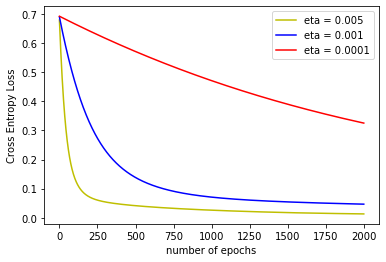

In [20]:
datas = loadData()
trainTarget = datas[3].astype(int)
testTarget = datas[5].astype(int) # caused issues for some reason

trainData = datas[0].reshape(3500,-1)
trainData = np.append(np.ones((trainData.shape[0],1)),trainData,axis=1) #add 1's to axis 1
testData = datas[2].reshape(145,-1)
testData = np.append(np.ones((testData.shape[0],1)),testData,axis=1) #add 1's to axis 1


w = np.zeros((trainData.shape[1],1))

#epochs
epochs = 2000

#reg
reg = 0 
#eta values -- learning rate
eta_1 = 0.005
eta_2 = 0.001 
eta_3 = 0.0001 

#error tol
error_tol = 0.0000001  # 10^-7

# learning rates
lng_1 = grad_descent(w, trainData, trainTarget, eta_1, epochs, reg, error_tol)
print(" Learning rate 1 is done")
lng_2 = grad_descent(w, trainData, trainTarget, eta_2, epochs, reg, error_tol)
print(" Learning rate 2 is done")
lng_3 = grad_descent(w, trainData, trainTarget, eta_3, epochs, reg, error_tol)
print(" Learning rate 3 is done")

#Plotting loss
plt.plot(lng_1[1], "-y", label = "eta = 0.005")
plt.plot(lng_2[1], "-b", label = "eta = 0.001")
plt.plot(lng_3[1], "-r", label = "eta = 0.0001")

#to clarify which plot is which data
plt.legend()

plt.ylabel("Cross Entropy Loss")
plt.xlabel("number of epochs")

plt.show() #show the plot that is generated


In the text box below, briefly discuss the impact of the learning rate $\eta$ on the training time. 

### MY ANSWER:
If $\eta$ is large from the graph we can see that we are getting more steep graph, this is good because $\eta$ means step size in the GD algorithm, and when $\eta$ is large it helps us to get the Cross Entropy Loss quickly therefore, we would like to have a large $\eta$. If we are having a small $\eta$ it is hard to predict the Cross Entropy Loss, and it is not desired. Therefore, we would like to have a large $\eta$ .

### Generalization [3 points]:
Fix the learning rate to $\eta=0.005$, and consider values for the regularization parameter $\lambda = 0.001,\, 0.01,\, 0.1$. Measure the classification error using the validation and test sets and state them in your answer in the text box below. Comment on the effect of regularization on performance as well as the rationale behind tuning $\lambda$ using the validation set.

In [21]:
""" Here you can write your code for the generalization test"""
# YOUR CODE HERE
datas = loadData()
trainTarget = datas[3].astype(int)
testTarget = datas[5].astype(int)
testData = datas[2].reshape(145, -1)
trainData = datas[0].reshape(3500, -1)
validTarget = datas[4].astype(int)
validData = datas[1].reshape(100, -1)

validData = np.append(np.ones((validData.shape[0],1)),validData,axis=1) #we will need this for validation tes
trainData = np.append(np.ones((trainData.shape[0],1)),trainData,axis=1)
testData  = np.append(np.ones((testData.shape[0],1)),testData,axis=1)

#initialize
w = np.zeros((trainData.shape[1],1))

#epochs
epochs = 2000

#eta
eta = 0.005

#reg values
reg_1 = 0.001
reg_2 = 0.01
reg_3 = 0.1

#error tolerance
error_tol = 0.0000001

lng_1 = grad_descent(w, testData, testTarget, eta, epochs, reg_1, error_tol)
lng_2 = grad_descent(w, testData, testTarget, eta, epochs, reg_2, error_tol)
lng_3 = grad_descent(w, testData, testTarget, eta, epochs, reg_3, error_tol)

print("0.001 error is (for test set) = ", crossEntropyLoss(lng_1[0],testData,testTarget,reg_1))
print("0.01 error is (for test set) = ", crossEntropyLoss(lng_2[0],testData,testTarget,reg_2))
print("0.1 error is (for test set) = ", crossEntropyLoss(lng_3[0],testData,testTarget,reg_3))

lng_1 = grad_descent(w, validData, validTarget, eta, epochs, reg_1, error_tol)
lng_2 = grad_descent(w, validData, validTarget, eta, epochs, reg_2, error_tol)
lng_3 = grad_descent(w, validData, validTarget, eta, epochs, reg_3, error_tol)

print("0.001 error is (for valid set) = ", crossEntropyLoss(lng_1[0],validData,validTarget,reg_1))
print("0.01 error is (for valid set) = ", crossEntropyLoss(lng_2[0],validData,validTarget,reg_2))
print("0.1 error is (for valid set) = ", crossEntropyLoss(lng_3[0],validData,validTarget,reg_3))


0.001 error is (for test set) =  0.006524973881526034
0.01 error is (for test set) =  0.029363729230038084
0.1 error is (for test set) =  0.09923872992128321
0.001 error is (for valid set) =  0.0044348798499092455
0.01 error is (for valid set) =  0.022218118317032014
0.1 error is (for valid set) =  0.08743788396185392


### Effect of Regularization Parameter on Performance

$\lambda$ is used to control the differences between C Entropy Loss over different data sets. The best $\lambda$ to choose is $\lambda$ = 0.001 because, the Cross Entropy Losses seems to be equally distributed, and they are seem to be lower than different $\lambda$ parameter values.

Rationale behind using $\lambda$ in validation model is that, since the validation model does not have training model data, we don't know how to measure different parameters for it. So to get these parameters such as $\lambda$, we can try different combinations of different parameters to obtain a better result.